# Predictions for 20 Complete Genes


Hs->Hs

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


Tensorflow version:

In [13]:
tf.__version__

'2.9.0'

Python Version:

In [14]:
import sys
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [15]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)


#INIT 
data_dir=''
fname=''
models_dir=''

Not running on CoLab
Num GPUs Available: 1
Found GPU at: /device:GPU:0
Fri Feb 24 19:43:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8    N/A /  N/A |   1852MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                 

In [16]:
########################################
# PARAMS
########################################

#-------------------- Mm -> Tt-----------------------------
species_train_model_name = 'TFM_LSTMBidiAttention'
cross_test_name = 'Predict_Hs_to_Hs_20G_Complete_1'
fname = 'hg38_RS_DL_Pad_W50_20GENES_CODED2CH.csv'
dirname = 'ALL_HG38'
#-------------------------------------------------

padding=True
#ptrain = 0.7
random_seed=2022

numchannels=2

if numchannels==3:
   categories_size=60
else:
   categories_size=20

if padding==True:
    categories_size=categories_size+1

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/'+dirname+'/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/'+dirname+'/W50'
    models_dir= '/content/drive/MyDrive/MODELS'
#########################################

SPECIES TRAIN MODEL:

In [17]:
saved_model =  species_train_model_name+'.h5'
savedmodelfile = os.path.join(models_dir, saved_model)
print("SPECIES TRAIN MODEL FILE: {}".format(savedmodelfile))

SPECIES TRAIN MODEL FILE: ./SAVED_MODELS\TFM_LSTMBidiAttention.h5


SPECIES TEST DATASET:

In [18]:
datafile = os.path.join(data_dir, fname)
print("SPECIES TEST DATASET: {}".format(datafile))
data = pd.read_csv(datafile,sep=";")
print("shape data={}".format(data.shape))

SPECIES TEST DATASET: ../../data/datasets/ALL_HG38/W50\hg38_RS_DL_Pad_W50_20GENES_CODED2CH.csv
shape data=(198626, 104)


In [19]:
print(data.head)

<bound method NDFrame.head of                GENE    POS  EDITING  P1  P2  P3  P4  P5  P6  P7  ...  P92  \
0       APLP2_APLP2      0        0  20  20  20  20  20  20  20  ...   16   
1       APLP2_APLP2      2        0  20  20  20  20  20  20  20  ...   17   
2       APLP2_APLP2     25        0  20  20  20  20  20  20  20  ...    3   
3       APLP2_APLP2     26        0  20  20  20  20  20  20  20  ...    8   
4       APLP2_APLP2     30        0  20  20  20  20  20  20  20  ...    6   
...             ...    ...      ...  ..  ..  ..  ..  ..  ..  ..  ...  ...   
198621    LEF1_LEF1  66380        0   0   0  10   5   0   0   0  ...   17   
198622    LEF1_LEF1  66383        0   5   0   0   0  10   0   0  ...    7   
198623    LEF1_LEF1  66384        0   0   0   0  10   0   0   6  ...   17   
198624    LEF1_LEF1  66385        0   0   0  10   0   0   6   1  ...    7   
198625    LEF1_LEF1  66396        0   1   6  18  11   6   3  13  ...   17   

        P93  P94  P95  P96  P97  P98  P99  P1

In [20]:
# Data Test
data_test  =data
data_y_test=data['EDITING']
print("Selecting data for testing... data_test: {} data_y_test: {}".format(data_test.shape,data_y_test.shape))
print("TEST LABELS:")
print(data_y_test.value_counts())

Selecting data for testing... data_test: (198626, 104) data_y_test: (198626,)
TEST LABELS:
0    193796
1      4830
Name: EDITING, dtype: int64


Recover saved model

In [21]:
#Load the trained model from disk
import os.path

if os.path.exists(savedmodelfile):
    model = tf.keras.models.load_model(savedmodelfile)
    # Show the model architecture
    model.summary()
else:
    print("ERROR model {} not found ".format(savedmodelfile))           



Model: "TFM_LSTMBidiAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout_2 (Dropout)            (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 101, 1)       513         ['dropout_2[0][0]']              
                                                                              

In [22]:
#PREDICTIONS
#DataGenerator converts on the fly from raw data to one-hot
if GOOGLE_COLAB==False:
    from rnaed import DataGenerator
else:
    from RNAEd import DataGenerator


#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = data_test.iloc[:,3:].shape[1]
num_tokens = categories_size

pred_generator       = DataGenerator( data_test.iloc[:,3:], data_y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )
model_prediction = model.predict(pred_generator,verbose=1)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

198626/198626 [==============================] - 2936s 15ms/step


In [23]:
print(data_test.shape)
print(data_y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(198626, 104)
(198626,)
(198626, 1)
(198626, 1)


In [24]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+cross_test_name+"\n---------------------------------")
kappa = cohen_kappa_score(data_y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(data_y_test, model_prediction_binary))

MODEL Predict_Hs_to_Hs_20G_Complete_1
---------------------------------
Kappa: 0.285
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    193796
           1       0.19      0.93      0.31      4830

    accuracy                           0.90    198626
   macro avg       0.59      0.91      0.63    198626
weighted avg       0.98      0.90      0.93    198626



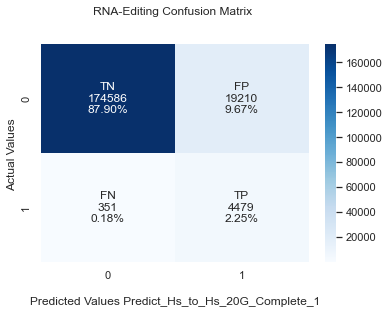

In [25]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(data_y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ cross_test_name)
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])
plt.show()

AUC: 0.95


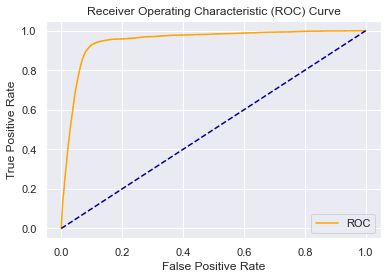

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(data_y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(data_y_test, model_prediction)
plot_roc_curve(fpr, tpr)

RESULTS INSIGHT

In [27]:
results_data = data_test
if 'RESULT_TYPE' not in results_data.columns:
    #insert column at position 3
    results_data.insert(3,"RESULT_TYPE", None)
    results_data.insert(4,"PROB_PRED",model_prediction)
else:
    print("RESULT_TYPE already exists in the dataframe")

results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
0,APLP2_APLP2,0,0,None,0.067267,20,20,20,20,20,...,16,7,17,7,17,7,2,6,11,16
1,APLP2_APLP2,2,0,None,0.070152,20,20,20,20,20,...,17,7,17,7,2,6,11,16,16,6
2,APLP2_APLP2,25,0,None,0.305264,20,20,20,20,20,...,3,8,3,6,11,6,1,11,11,11
3,APLP2_APLP2,26,0,None,0.375850,20,20,20,20,20,...,8,3,6,11,6,1,11,11,11,6
4,APLP2_APLP2,30,0,None,0.259487,20,20,20,20,20,...,6,1,11,11,11,6,6,10,5,0


In [ ]:
column_index=results_data.columns.get_loc('RESULT_TYPE')
i=0
for result in model_prediction_binary:
    #print("Comparing result={} with data_y_test={}".format(result[0],data_y_test.iloc[i]))
    if   result[0]==0 and data_y_test.iloc[i]==0:
       typeRes ="TN"
    elif result[0]==0 and data_y_test.iloc[i]==1:
       typeRes="FN"
    elif result[0]==1 and data_y_test.iloc[i]==0:
       typeRes="FP"
    elif result[0]==1 and data_y_test.iloc[i]==1:
       typeRes="TP"
    results_data.iloc[i, column_index]=typeRes
    i+=1
    
results_data.head()

In [ ]:
#Save the results into a file
if GOOGLE_COLAB==False:
    report_dir="./report"
else:
    report_dir="/content/drive/MyDrive/REPORT"

results_csv_file  =cross_test_name + "_Results.csv"
results_excel_file=cross_test_name + "_Results.xlsx"
results_data.to_csv(os.path.join(report_dir,results_csv_file))
results_data.to_excel(os.path.join(report_dir,results_excel_file))

Now, we are going to find the record with highest probability and category TP (True Positive) as a good model of TP data,
and alternatively, the best representative of TN, using the lowest value

In [ ]:
subset_TP=results_data.loc[results_data['RESULT_TYPE'] == 'TP']
prototype_of_TP_id=subset_TP['PROB_PRED'].idxmax()
print("rowid best TP = {}".format(prototype_of_TP_id))
print(results_data.loc[prototype_of_TP_id,])

In [ ]:
subset_TN=results_data.loc[results_data['RESULT_TYPE'] == 'TN']
prototype_of_TN_id=subset_TN['PROB_PRED'].idxmin()
print("rowid best TN = {}".format(prototype_of_TN_id))
print(results_data.loc[prototype_of_TN_id,])